In [1]:
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [2]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [3]:
movies.head()

,primarytitle,domesticgross,productionbudget,runtimeminutes,release_year,release_week,g_rating,pg_rating,pg13_rating,r_rating,...,guy_ritchie,david_gordon_green,christopher_nolan,todd_phillips,warner_bros,universal,fox,buena_vista,sony,paramount
0,"10,000 BC",94784201,105000000,109.0,2008,10,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,102 Dalmatians,66941559,85000000,100.0,2000,47,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,10 Cloverfield Lane,72082999,15000000,103.0,2016,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,10 Days in a Madhouse,14616,12000000,111.0,2015,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10th & Wolf,54702,8000000,107.0,2006,33,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
movies.describe()

,domesticgross,productionbudget,runtimeminutes,release_year,release_week,g_rating,pg_rating,pg13_rating,r_rating,action,...,guy_ritchie,david_gordon_green,christopher_nolan,todd_phillips,warner_bros,universal,fox,buena_vista,sony,paramount
count,2.788000e+03,2.788000e+03,2780.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.00000,...,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000,2788.000000
mean,5.933330e+07,4.549039e+07,107.426619,2009.068149,29.367288,0.025825,0.146341,0.353659,0.389885,0.26363,...,0.002869,0.003228,0.003228,0.003587,0.097202,0.086083,0.080703,0.069225,0.067791,0.060258
std,7.963726e+07,4.990510e+07,17.954723,5.507703,14.646044,0.158641,0.353512,0.478191,0.487812,0.44068,...,0.053500,0.056735,0.056735,0.059793,0.296286,0.280537,0.272427,0.253882,0.251431,0.238007
min,4.230000e+02,7.000000e+03,15.000000,2000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.184761e+07,1.200000e+07,95.000000,2004.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.401892e+07,2.910000e+07,105.000000,2009.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.343355e+07,6.000000e+07,117.000000,2014.000000,42.000000,0.000000,0.000000,1.000000,1.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.583730e+08,4.106000e+08,219.000000,2019.000000,53.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


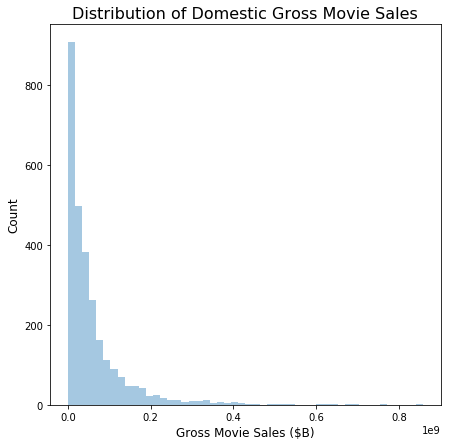

In [5]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['domesticgross'], kde=False)
plt.title("Distribution of Domestic Gross Movie Sales", fontsize=16)
plt.xlabel("Gross Movie Sales ($B)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('sales_dist.png')

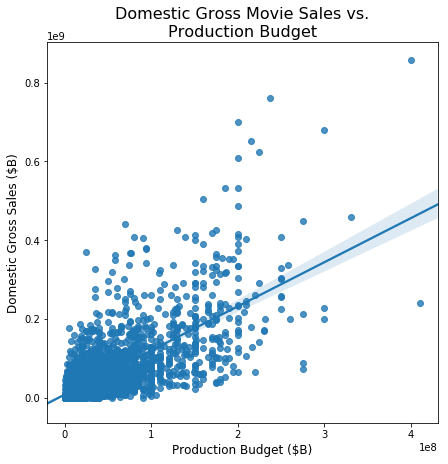

In [6]:
plt.figure(figsize=(7, 7))
sns.regplot(data=movies,x='productionbudget',y='domesticgross')
plt.title("Domestic Gross Movie Sales vs.\nProduction Budget", fontsize=16)
plt.xlabel("Production Budget ($B)", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('sales_vs_budget.png')

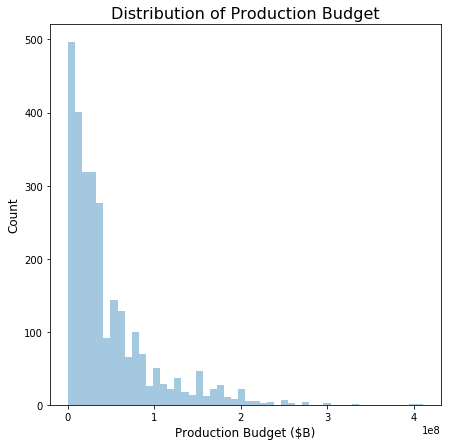

In [7]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['productionbudget'], kde=False)
plt.title("Distribution of Production Budget", fontsize=16)
plt.xlabel("Production Budget ($B)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('budget_dist.png')

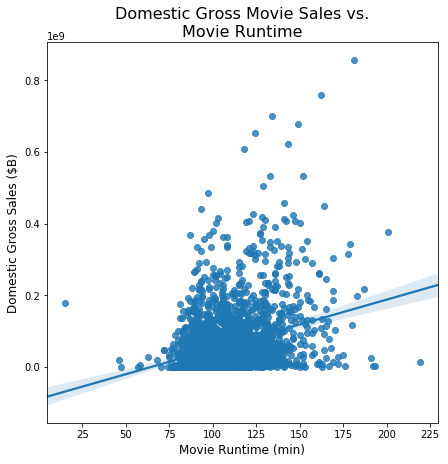

In [8]:
plt.figure(figsize=(7, 7))
sns.regplot(data=movies,x='runtimeminutes',y='domesticgross')
plt.title("Domestic Gross Movie Sales vs.\nMovie Runtime", fontsize=16)
plt.xlabel("Movie Runtime (min)", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('sales_vs_runtime.png')

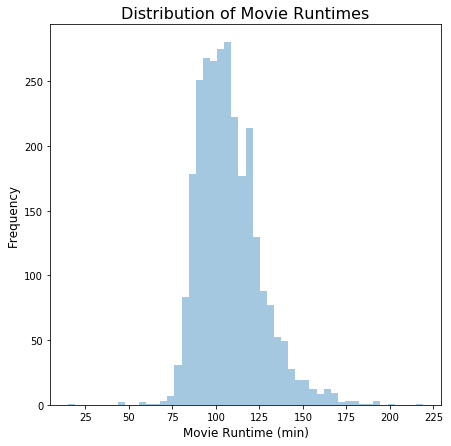

In [9]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['runtimeminutes'].dropna(), kde=False)
plt.title("Distribution of Movie Runtimes", fontsize=16)
plt.xlabel("Movie Runtime (min)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.savefig('runtimes_dist.png')

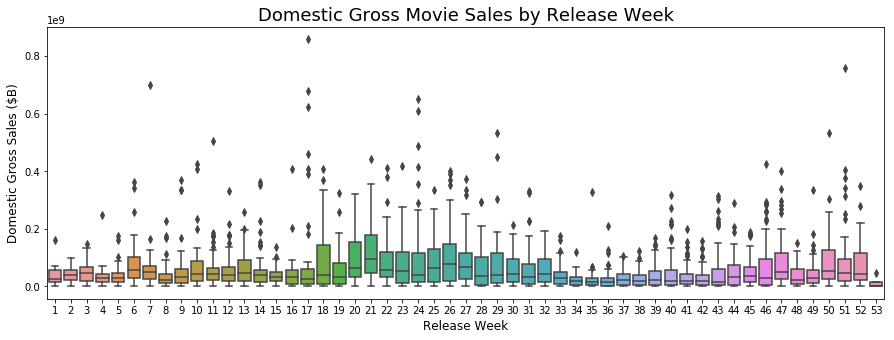

In [10]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_week")
plt.title("Domestic Gross Movie Sales by Release Week", fontsize=18)
plt.xlabel("Release Week", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('box_by_week.png')

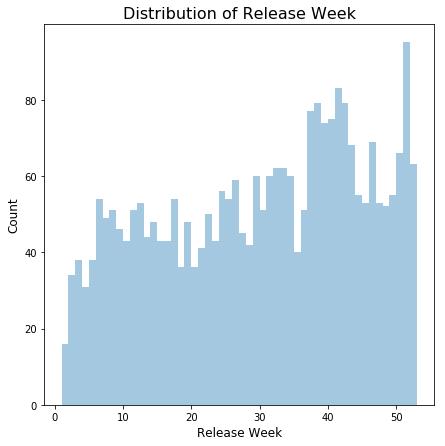

In [11]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['release_week'], kde=False, bins=52)
plt.title("Distribution of Release Week", fontsize=16)
plt.xlabel("Release Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('week_dist.png')

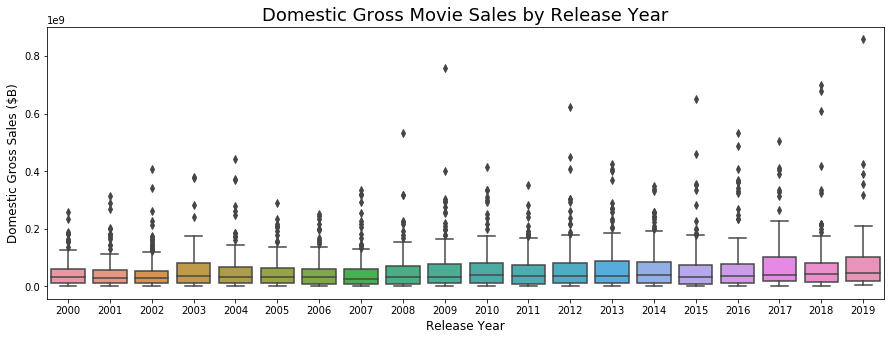

In [12]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=movies, y="domesticgross", x="release_year")
plt.title("Domestic Gross Movie Sales by Release Year", fontsize=18)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('box_by_year.png')

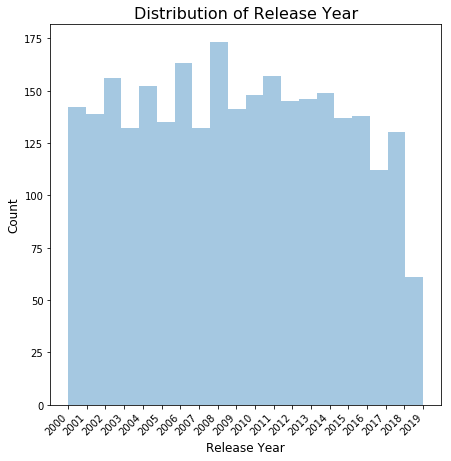

In [13]:
plt.figure(figsize=(7, 7))
sns.distplot(movies['release_year'], kde=False, bins=20)
plt.title("Distribution of Release Year", fontsize=16)
plt.xticks(list(range(2000,2020)), rotation=45, horizontalalignment='right')
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.savefig('year_dist.png')

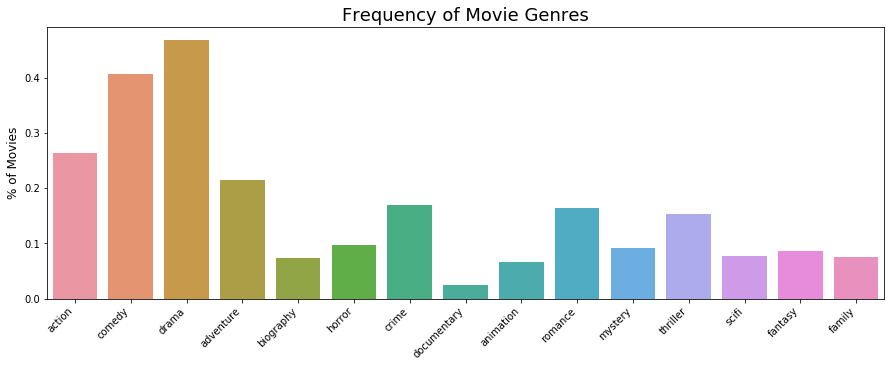

In [14]:
genre_list = ['action','comedy','drama','adventure','biography','horror','crime','documentary',
              'animation','romance','mystery','thriller','scifi','fantasy','family']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[genre_list].melt(), y="value", x="variable", ci=None) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movie Genres", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('genre_freq.png')

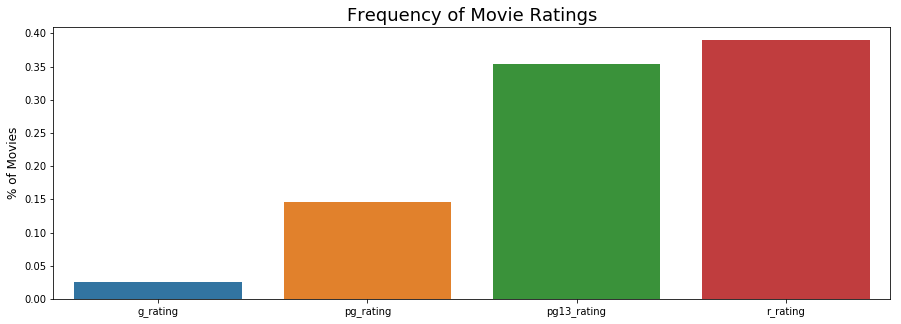

In [15]:
rating_list = ['g_rating','pg_rating','pg13_rating','r_rating']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[rating_list].melt(), y="value", x="variable", ci=None) 
plt.title("Frequency of Movie Ratings", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('rating_freq.png')

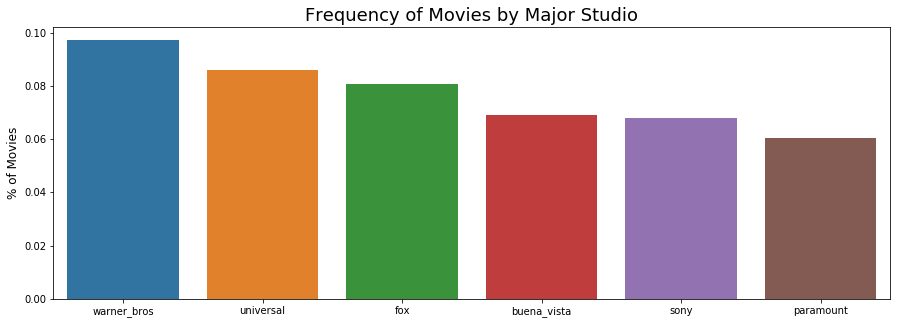

In [16]:
studio_list = ['warner_bros','universal','fox','buena_vista','sony','paramount']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[studio_list].melt(), y="value", x="variable", ci=None) 
plt.title("Frequency of Movies by Major Studio", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('studio_freq.png')

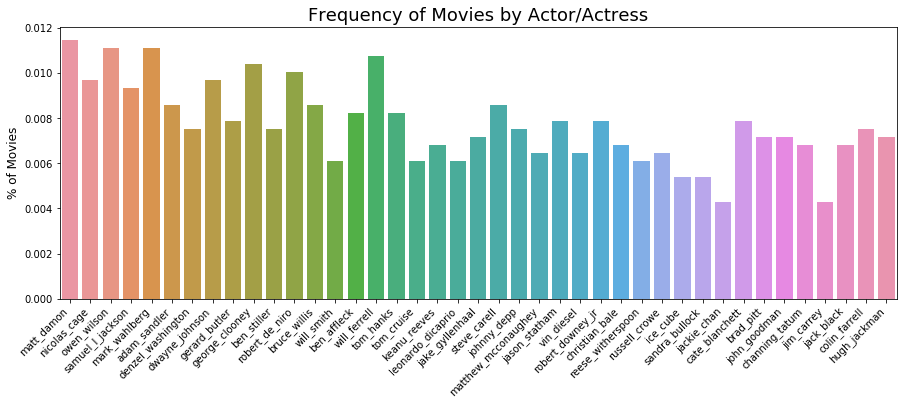

In [17]:
actor_list = ['matt_damon','nicolas_cage', 'owen_wilson', 'samuel_l_jackson', 'mark_wahlberg',
       'adam_sandler', 'denzel_washington', 'dwayne_johnson', 'gerard_butler',
       'george_clooney', 'ben_stiller', 'robert_de_niro', 'bruce_willis',
       'will_smith', 'ben_affleck', 'will_ferrell', 'tom_hanks', 'tom_cruise',
       'keanu_reeves', 'leonardo_dicaprio', 'jake_gyllenhaal', 'steve_carell',
       'johnny_depp', 'matthew_mcconaughey', 'jason_statham', 'vin_diesel',
       'robert_downey_jr', 'christian_bale', 'reese_witherspoon',
       'russell_crowe', 'ice_cube', 'sandra_bullock', 'jackie_chan',
       'cate_blanchett', 'brad_pitt', 'john_goodman', 'channing_tatum',
       'jim_carrey', 'jack_black', 'colin_farrell', 'hugh_jackman']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[actor_list].melt(), y="value", x="variable", ci=None) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movies by Actor/Actress", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('actor_freq.png')

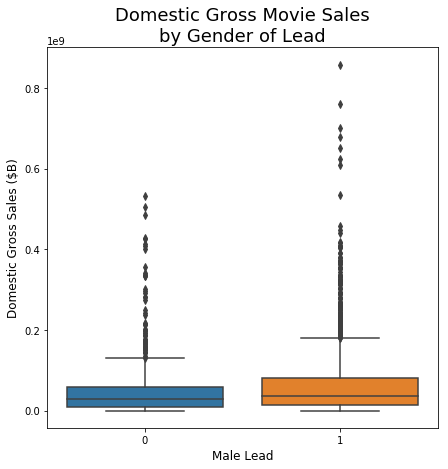

In [18]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=movies, y="domesticgross", x="male_lead")
plt.title("Domestic Gross Movie Sales\nby Gender of Lead", fontsize=18)
plt.xlabel("Male Lead", fontsize=12)
plt.ylabel("Domestic Gross Sales ($B)", fontsize=12)
plt.savefig('box_by_lead_gender.png')

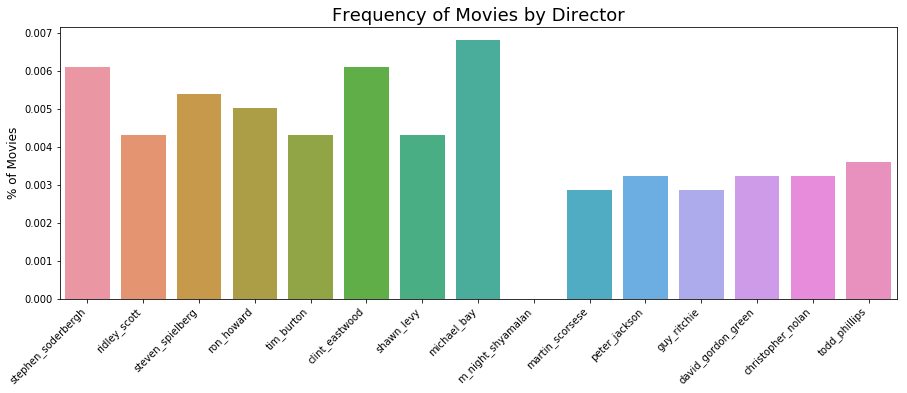

In [19]:
director_list = ['stephen_soderbergh', 'ridley_scott', 'steven_spielberg', 'ron_howard',
       'tim_burton', 'clint_eastwood', 'shawn_levy', 'michael_bay',
       'm_night_shyamalan', 'martin_scorsese', 'peter_jackson', 'guy_ritchie',
       'david_gordon_green', 'christopher_nolan', 'todd_phillips']
plt.figure(figsize=(15, 5))
sns.barplot(data=movies[director_list].melt(), y="value", x="variable", ci=None) 
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("Frequency of Movies by Director", fontsize=18)
plt.xlabel("", fontsize=12)
plt.ylabel("% of Movies", fontsize=12)
plt.savefig('director_freq.png')

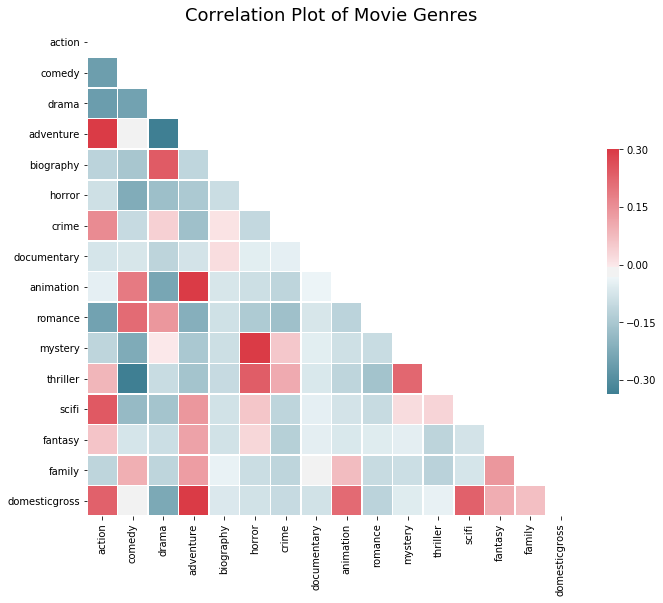

In [20]:
# Compute the correlation matrix
corr = movies[genre_list + ['domesticgross']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=1, yticklabels=1,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.title("Correlation Plot of Movie Genres", fontsize=18)
plt.savefig('genre_corr.png')

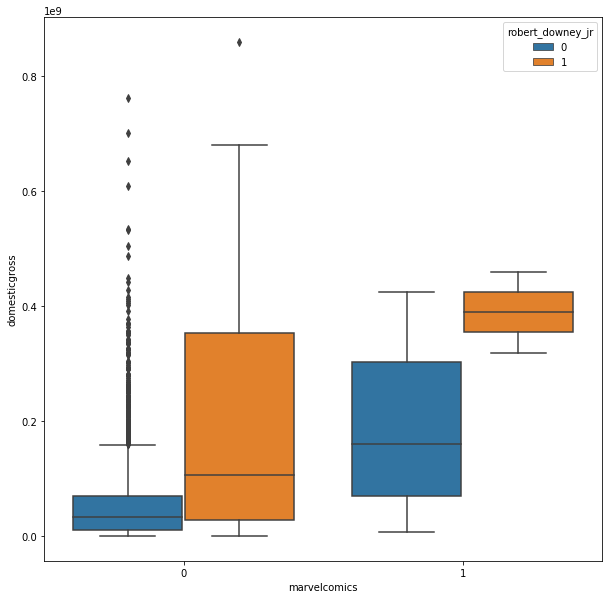

In [21]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="marvelcomics", hue="robert_downey_jr")

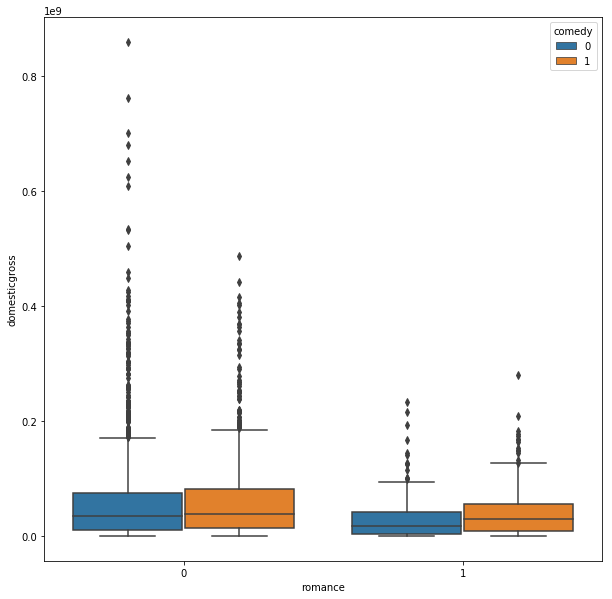

In [22]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="romance", hue="comedy")

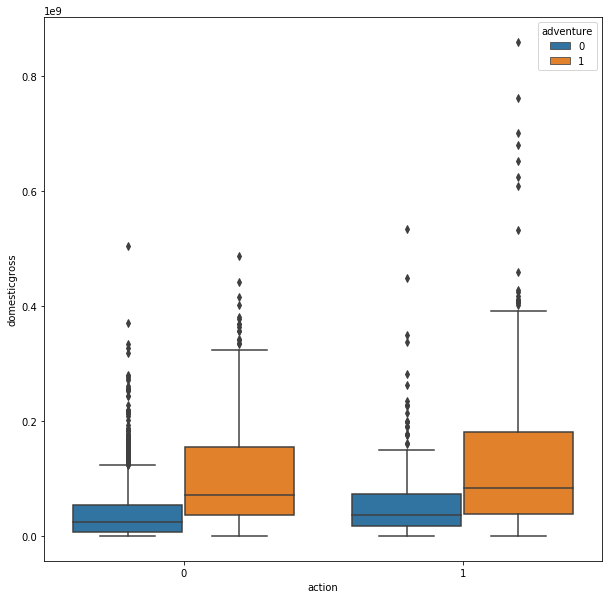

In [23]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=movies, y="domesticgross", x="action", hue="adventure")